In [1]:
import numpy as np 
import pandas as pd 
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("./train.csv")
df1=df
df.head(5)

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,NaN,31
1,4339,EPX,Travel Agency,Online,Cancellation Plan,0,85,SINGAPORE,69.0,0.00,NaN,36
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,11,MALAYSIA,19.8,11.88,NaN,75
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0,16,INDONESIA,20.0,0.00,NaN,32
4,13816,EPX,Travel Agency,Online,Cancellation Plan,0,10,"KOREA, REPUBLIC OF",15.0,0.00,NaN,29


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50553 entries, 0 to 50552
Data columns (total 12 columns):
ID                      50553 non-null int64
Agency                  50553 non-null object
Agency Type             50553 non-null object
Distribution Channel    50553 non-null object
Product Name            50553 non-null object
Claim                   50553 non-null int64
Duration                50553 non-null int64
Destination             50553 non-null object
Net Sales               50553 non-null float64
Commision (in value)    50553 non-null float64
Gender                  14600 non-null object
Age                     50553 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 4.6+ MB


So, there are 4 numerical columns and 7 categorical columns


Now, lets check which columns have the null values

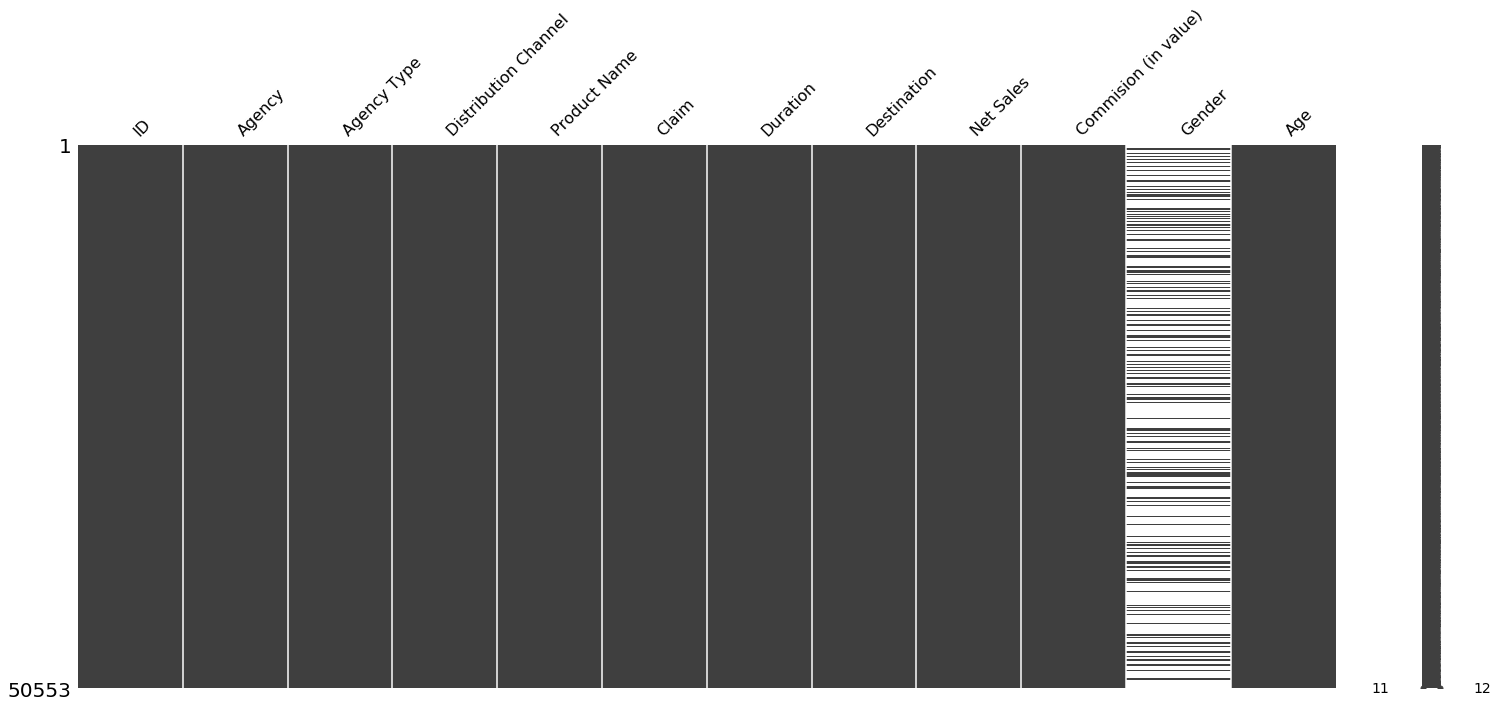

In [4]:
missingno.matrix(df)

"Black" in the data depicts the column is fill with data and "White" depicts they have null values in that particular area

So, we can conclude that only "Gender" have the null values and seems quite much

Lets see whats the number of null values in the "Gender" column

In [5]:
df['Gender'].isnull().sum()

35953

35953/50553 are null values, nearly 71.2% data in the column are null values.

I have replaced the null values with another category called "Not Specified"

In [6]:
df.fillna('Not Specified',inplace=True)

In [7]:
df.isnull().sum()

ID                      0
Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Claim                   0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Gender                  0
Age                     0
dtype: int64

There is no null values now

First make an another dataframe which consist of only numerical columns from df

In [8]:
df_numerical=df._get_numeric_data()
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50553 entries, 0 to 50552
Data columns (total 6 columns):
ID                      50553 non-null int64
Claim                   50553 non-null int64
Duration                50553 non-null int64
Net Sales               50553 non-null float64
Commision (in value)    50553 non-null float64
Age                     50553 non-null int64
dtypes: float64(2), int64(4)
memory usage: 2.3 MB


****Now lets look at the spread of the numerical data****

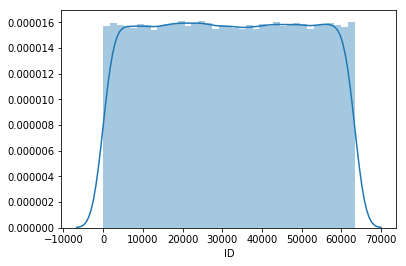

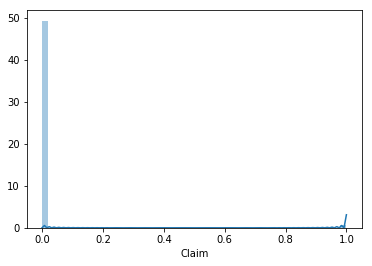

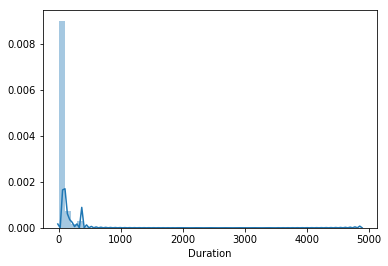

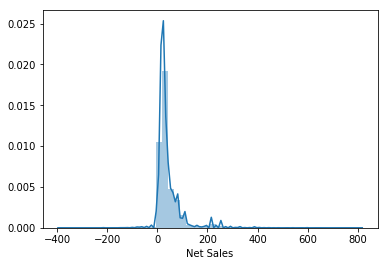

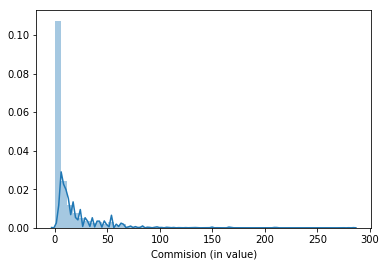

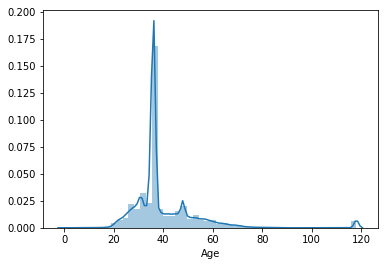

In [9]:
for i, col in enumerate(df_numerical.columns):
    plt.figure(i)
    sns.distplot(df_numerical[col])

**From the graph we can conclude:**

*Duration*: Data in this column is highly right skewed.

*Net Sales and Commison*: These both column seems to related but the graph plot shows disparency as low net sales     shows high commison which is not pratically possible.

*Age*: Age is random so its distribution can be random.

**Lets check the data in "Duration" column**

In [10]:
df['Duration'].describe()

count    50553.000000
mean        49.425969
std        101.434647
min         -2.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

We have negative values in this Duration column but can time be negative? **NO**

**Lets see how many negative values we have in Duration column**

In [11]:
df10=df['Duration']<0
df10.sum()

3

So, there are 3 negative values in Duration column. I am gonna replace those with the mean value

In [12]:
df.loc[df['Duration'] < 0, 'Duration'] = 49.317

Previously we have checked that some columns have low Net Sales but High Commison but thats not possible

Lets see how many such columns we have here

In [13]:
df6= df['Net Sales']<df['Commision (in value)']
df6.sum()

1598

We gonna make all comission value 0 where net sales is 0.

In [14]:
df.loc[df['Net Sales'] == 0.0, 'Commision (in value)'] = 0

In [15]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

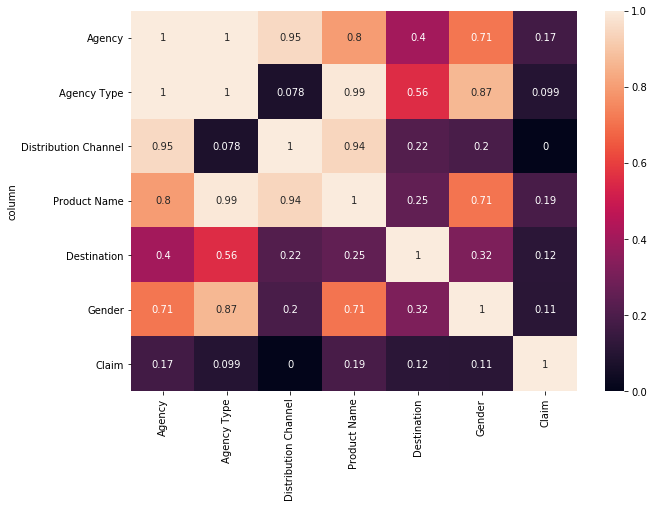

In [16]:
categorical=['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',  'Destination','Gender','Claim']
cramers=pd.DataFrame({i:[cramers_v(df[i],df[j]) for j in categorical] for i in categorical})
cramers['column']=[i for i in categorical if i not in ['memberid']]
cramers.set_index('column',inplace=True)

#categorical correlation heatmap

plt.figure(figsize=(10,7))
sns.heatmap(cramers,annot=True)
plt.show()

**Observation:**

We can see the Co-relation between the Categorical columns.

Can conclude that the cloumn "Agency Type' have high corelation with some of the columns like "Agency","Product Name" thus we can drop "Agency Type".

**Lets Check how Gender is related to the Claim column**

In [17]:
test=[(df[df['Gender']=='Not Specified']['Claim'].value_counts()/len(df[df['Gender']=='Not Specified']['Claim']))[1],(df[df['Gender']=='M']['Claim'].value_counts()/len(df[df['Gender']=='M']['Claim']))[1],
      (df[df['Gender']=='F']['Claim'].value_counts()/len(df[df['Gender']=='F']['Claim']))[1]]
test

[0.006258170389119128, 0.031619503122093794, 0.03930439700268627]

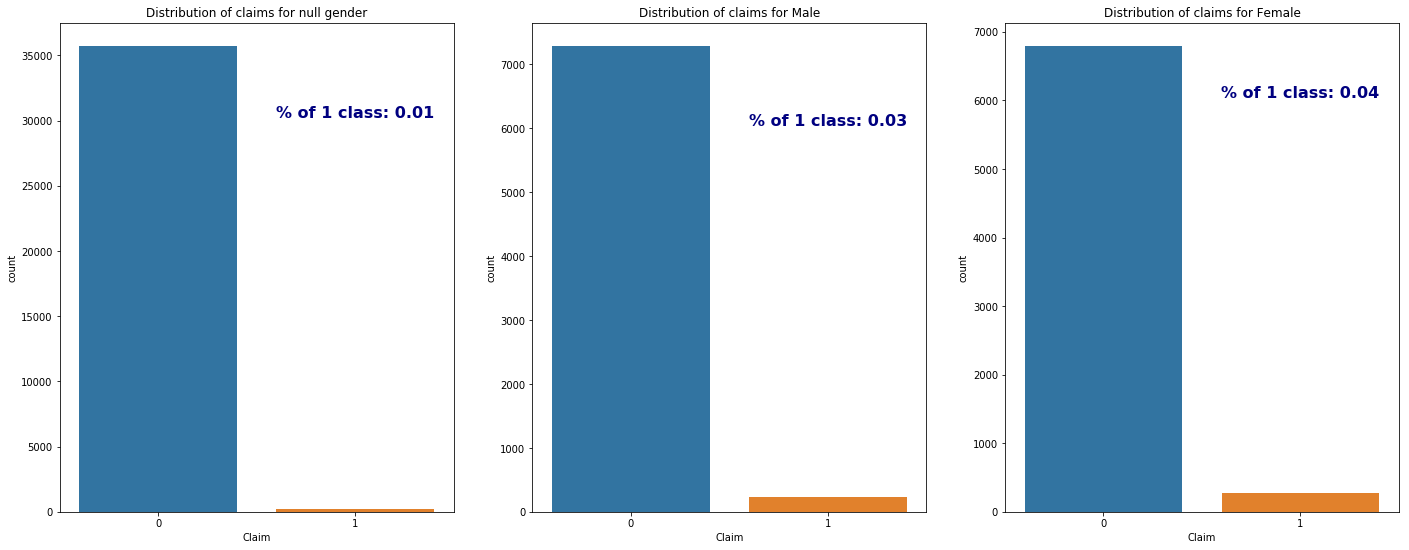

In [18]:
fig, axes=plt.subplots(1,3,figsize=(24,9))
sns.countplot(df[df['Gender']=='Not Specified']['Claim'],ax=axes[0])
axes[0].set(title='Distribution of claims for null gender')
axes[0].text(x=1,y=30000,s=f'% of 1 class: {round(test[0],2)}',fontsize=16,weight='bold',ha='center',va='bottom',color='navy')
sns.countplot(df[df['Gender']=='M']['Claim'],ax=axes[1])
axes[1].set(title='Distribution of claims for Male')
axes[1].text(x=1,y=6000,s=f'% of 1 class: {round(test[1],2)}',fontsize=16,weight='bold',ha='center',va='bottom',color='navy')
sns.countplot(df[df['Gender']=='F']['Claim'],ax=axes[2])
axes[2].set(title='Distribution of claims for Female')
axes[2].text(x=1,y=6000,s=f'% of 1 class: {round(test[2],2)}',fontsize=16,weight='bold',ha='center',va='bottom',color='navy')
plt.show()

**Observation :**
Female Gender have highest number of Claims approved. Though the numbers aren't that descriptive to conclude to a decision

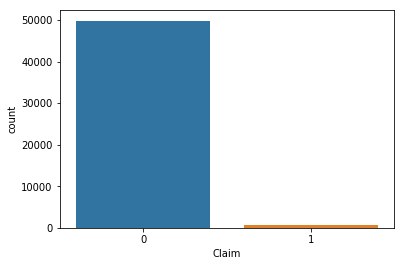

In [19]:
sns.countplot(df['Claim'])

From the above graph we can say that there is high imbalance in the target variable. We will see how to deal with that a little later


Lets see which features are important for the prediction using **Chi Square Test**

In [20]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, df):
        self.df = df
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = ss.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [21]:
X = df.drop(['Claim'], axis=1)
ct = ChiSquare(df)
for c in X.columns:
    ct.TestIndependence(c, 'Claim')

ID is NOT an important predictor. (Discard ID from model)
Agency is IMPORTANT for Prediction
Agency Type is IMPORTANT for Prediction
Distribution Channel is NOT an important predictor. (Discard Distribution Channel from model)
Product Name is IMPORTANT for Prediction
Duration is IMPORTANT for Prediction
Destination is IMPORTANT for Prediction
Net Sales is IMPORTANT for Prediction
Commision (in value) is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Age is IMPORTANT for Prediction


According to the **Chi Square Test** Distribution Channel is not important thus I am dropping the column. Also as discussed above "Agency Type" is gonna dropped

In [22]:
df.drop(columns=['Distribution Channel','Agency Type'],axis=1,inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50553 entries, 0 to 50552
Data columns (total 10 columns):
ID                      50553 non-null int64
Agency                  50553 non-null object
Product Name            50553 non-null object
Claim                   50553 non-null int64
Duration                50553 non-null float64
Destination             50553 non-null object
Net Sales               50553 non-null float64
Commision (in value)    50553 non-null float64
Gender                  50553 non-null object
Age                     50553 non-null int64
dtypes: float64(3), int64(3), object(4)
memory usage: 3.9+ MB


In [24]:
y=df['Claim']


In [25]:
x=df
x.drop(columns='Claim',axis=1,inplace=True)

In [26]:
x_dummy=pd.get_dummies(x,columns=['Agency','Gender','Product Name','Destination'],drop_first=True)
x_dummy.head()

,ID,Duration,Net Sales,Commision (in value),Age,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,3433,7.0,0.0,0.00,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4339,85.0,69.0,0.00,36,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34590,11.0,19.8,11.88,75,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55816,16.0,20.0,0.00,32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13816,10.0,15.0,0.00,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=10, verbose=3)
rfe.fit(x_dummy, y)
rfe_df1 = rfe.fit_transform(x_dummy, y)

Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
F

Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 fe

In [28]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_dummy.columns)))

Features sorted by their rank:
[(1, 'Agency_EPX'), (1, 'Agency_TST'), (1, 'Destination_MYANMAR'), (1, 'Destination_NEPAL'), (1, 'Gender_Not Specified'), (1, 'Product Name_2 way Comprehensive Plan'), (1, 'Product Name_24 Protect'), (1, 'Product Name_Basic Plan'), (1, 'Product Name_Travel Cruise Protect'), (1, 'Product Name_Value Plan'), (2, 'Destination_ITALY'), (3, 'Destination_CZECH REPUBLIC'), (4, 'Product Name_Annual Travel Protect Gold'), (5, 'Product Name_Annual Silver Plan'), (6, 'Product Name_Annual Gold Plan'), (7, 'Agency_RAB'), (8, 'Destination_SRI LANKA'), (9, 'Destination_SOUTH AFRICA'), (10, 'Product Name_Single Trip Travel Protect Platinum'), (11, 'Agency_C2B'), (12, 'Destination_INDIA'), (13, 'Agency_ART'), (14, 'Agency_JZI'), (15, 'Agency_TTW'), (16, 'Destination_SINGAPORE'), (17, 'Destination_MALAYSIA'), (18, 'Destination_PHILIPPINES'), (19, 'Destination_CAMBODIA'), (20, 'Product Name_Cancellation Plan'), (21, 'Product Name_Single Trip Travel Protect Silver'), (22, 'De

In [29]:
X=x_dummy[['Agency_EPX','Agency_TST','Gender_Not Specified','Product Name_2 way Comprehensive Plan','Product Name_24 Protect','Product Name_Basic Plan','Product Name_Comprehensive Plan','Product Name_Premier Plan','Product Name_Travel Cruise Protect','Product Name_Value Plan']]

In [30]:
X.head(5)

,Agency_EPX,Agency_TST,Gender_Not Specified,Product Name_2 way Comprehensive Plan,Product Name_24 Protect,Product Name_Basic Plan,Product Name_Comprehensive Plan,Product Name_Premier Plan,Product Name_Travel Cruise Protect,Product Name_Value Plan
0,0,0,1,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=7)

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=7)
X_ov, y_ov = smote.fit_sample(X_train, y_train)

pd.value_counts(y_ov)

1    34863
0    34863
dtype: int64

In [34]:
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,roc_curve,confusion_matrix

In [35]:
lr_model=lr.fit(X_ov,y_ov)

In [36]:
lr_pred=lr.predict(X_test)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,lr_pred))
confusion_matrix(y_test,lr_pred)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     14949
           1       0.06      0.62      0.11       217

    accuracy                           0.85     15166
   macro avg       0.53      0.74      0.51     15166
weighted avg       0.98      0.85      0.91     15166



array([[12794,  2155],
       [   82,   135]], dtype=int64)

In [38]:
from sklearn.svm import LinearSVC
lsvc=LinearSVC()


In [39]:
svc_model=lsvc.fit(X_ov,y_ov)

In [40]:
lsvc_pred=lsvc.predict(X_test)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test,lsvc_pred))
confusion_matrix(y_test,lsvc_pred)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     14949
           1       0.06      0.62      0.11       217

    accuracy                           0.85     15166
   macro avg       0.53      0.74      0.51     15166
weighted avg       0.98      0.85      0.91     15166



array([[12794,  2155],
       [   82,   135]], dtype=int64)

In [42]:
rf=RandomForestClassifier(n_estimators=100)

In [43]:
rf_model=rf.fit(X_ov,y_ov)

In [44]:
rf_pred=rf.predict(X_test)

In [45]:
print(classification_report(y_test,rf_pred))
confusion_matrix(y_test,rf_pred)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     14949
           1       0.06      0.62      0.11       217

    accuracy                           0.85     15166
   macro avg       0.53      0.74      0.51     15166
weighted avg       0.98      0.85      0.91     15166



array([[12794,  2155],
       [   82,   135]], dtype=int64)

In [46]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()

In [47]:
dtc_model=dtc.fit(X_train,y_train)

In [48]:
dtc_pred=dtc.predict(X_test)

In [49]:

pd.set_option('display.max_columns',None)
print(classification_report(y_test,rf_pred))
confusion_matrix(y_test,rf_pred)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     14949
           1       0.06      0.62      0.11       217

    accuracy                           0.85     15166
   macro avg       0.53      0.74      0.51     15166
weighted avg       0.98      0.85      0.91     15166



array([[12794,  2155],
       [   82,   135]], dtype=int64)

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knc=KNeighborsClassifier()

In [51]:
knc_model=knc.fit(X_ov,y_ov)

In [52]:
knc_pred=knc.predict(X_test)

In [53]:
print(classification_report(y_test,knc_pred))
confusion_matrix(y_test,knc_pred)

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     14949
           1       0.01      0.12      0.02       217

    accuracy                           0.78     15166
   macro avg       0.50      0.46      0.45     15166
weighted avg       0.97      0.78      0.87     15166



array([[11861,  3088],
       [  190,    27]], dtype=int64)

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
random_estimators= RandomForestClassifier(random_state=9)
paramaters={'n_estimators': [10,20,30],'max_depth': [6,8],'min_samples_split': [6,8]}
grid=GridSearchCV(estimator=random_estimators,param_grid=paramaters)
grid.fit(X_ov,y_ov)
y_pred=grid.predict(X_test)
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     14949
           1       0.06      0.62      0.11       217

    accuracy                           0.85     15166
   macro avg       0.53      0.74      0.51     15166
weighted avg       0.98      0.85      0.91     15166



array([[12751,  2198],
       [   82,   135]], dtype=int64)

In [55]:
from sklearn.ensemble import VotingClassifier
vcf1 = VotingClassifier(estimators=[('lr',lr),('dtc',dtc),('rf',rf),('knc',knc)],voting='soft')
vcf1.fit(X_ov, y_ov)
y1_pred=vcf1.predict(X_test)
print(classification_report(y_test,y1_pred))
confusion_matrix(y_test,y1_pred)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     14949
           1       0.06      0.62      0.11       217

    accuracy                           0.86     15166
   macro avg       0.53      0.74      0.52     15166
weighted avg       0.98      0.86      0.91     15166



array([[12868,  2081],
       [   82,   135]], dtype=int64)

In [56]:
from sklearn.ensemble import BaggingClassifier

# Initialize Bagging Classifier
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), random_state=0,n_estimators=100,max_samples=100)

# Fit the model on training data
bagging_clf.fit(X_ov,y_ov)

# Predicted values of X_test
y_pred_bagging = bagging_clf.predict(X_test)

# accuracy 
print('Accuracy is ',bagging_clf.score(X_test,y_test))

# roc_score
score_bagging = roc_auc_score(y_test,y_pred_bagging)

print('AUC_ROC_score is ',score_bagging)
print(classification_report(y_test,y_pred_bagging))

Accuracy is  0.836937887379665
AUC_ROC_score is  0.7333587037710088
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     14949
           1       0.05      0.63      0.10       217

    accuracy                           0.84     15166
   macro avg       0.52      0.73      0.50     15166
weighted avg       0.98      0.84      0.90     15166



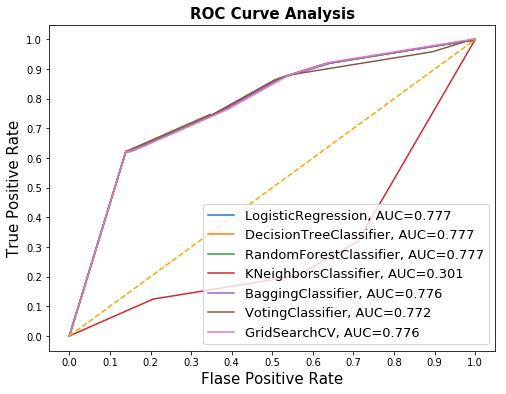

In [57]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

classifiers = [lr,dtc,rf,knc,bagging_clf,vcf1,grid]

for cls in classifiers:
    model = cls.fit(X_ov, y_ov)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()